In [1]:
import pandas as pd
import numpy as np
import mnist

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)

## Load the dataset

The MNIST database is available at http://yann.lecun.com/exdb/mnist/

The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value.

We will be using the `mnist` library to download images and labels from the MNIST database

The dataset is downloaded and cached in your temporary directory, so, calling the functions again, is much faster and doesn't hit the server.

In [2]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [3]:
print(f'train images shape: {train_images.shape}')
print(f'test images shape: {test_images.shape}')

train images shape: (60000, 28, 28)
test images shape: (10000, 28, 28)


## MNIST Images and labels

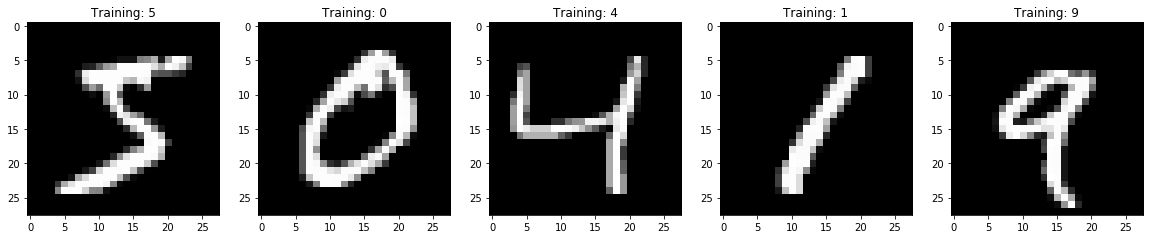

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_images[:5], train_labels[:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')

## Training and prediction using Logistic Regression

In [5]:
# Flatten images since the algorithm expects a 2d array

# move to utils.py
def flatten_images(images):
    n_samples, x_pixels, y_pixels = images.shape
    return images.reshape(n_samples, x_pixels*y_pixels)
    
train_data = flatten_images(train_images)
test_data = flatten_images(test_images)

# Scale data using minmax scaler, as it is more suited for images.
min_max_scaler = preprocessing.MinMaxScaler()
train_min_max = min_max_scaler.fit_transform(train_data)
test_min_max = min_max_scaler.transform(test_data)

In [6]:
# move to utils.py
def print_classification_vector(coef):
    # Pick max value from the co-efficient matrix
    scale = np.abs(coef).max()
    
    plt.figure(figsize=(20, 10))
    for i in range(coef.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(coef[i].reshape(28,28), interpolation='nearest',
                       cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)

### Baseline model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 199 seconds
Sparsity of the matrix: 8.545918367346939
Accuracy score: 0.9262
Classification vectors.. None
Wall time: 3min 19s


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


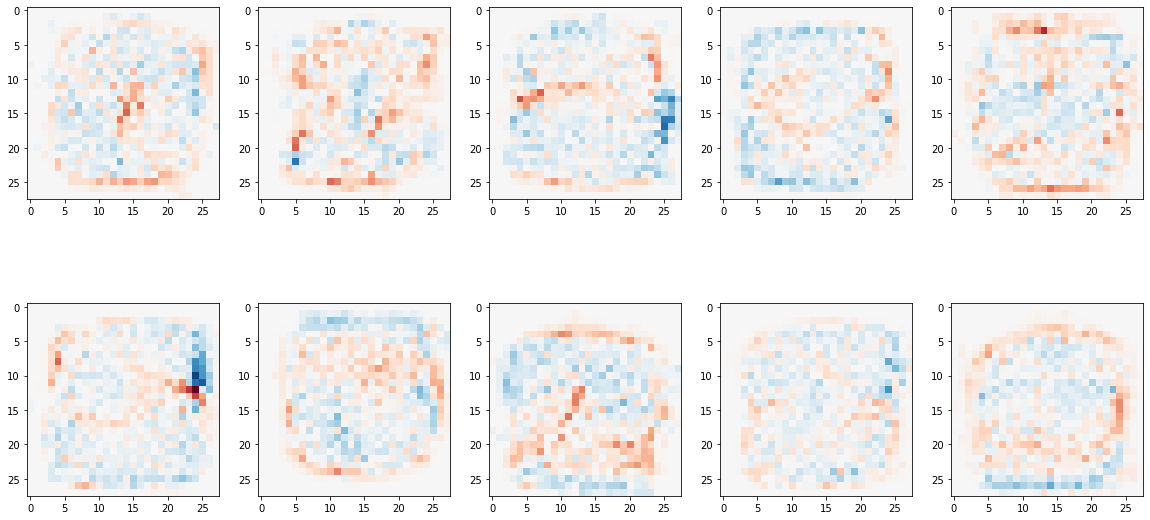

In [7]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems

clf = LogisticRegression(solver='saga', verbose=10)
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

It is a little surprising to see that a model that does not converge has an accuracy of 92.6%. The the classification vectors are not sparse, this tells us that the model might be generalizing a lot. Let us make sure the model converges and see how those classification vectors differ

### Improvements to Baseline: version 1

In this version, let us use tolerance for faster convergence and use L1 regularization to increase sparsity.

Sparsity of the matrix: 73.06122448979592
Accuracy score with l1 penalty: 0.8939
Classification vectors.. None
Wall time: 15.3 s


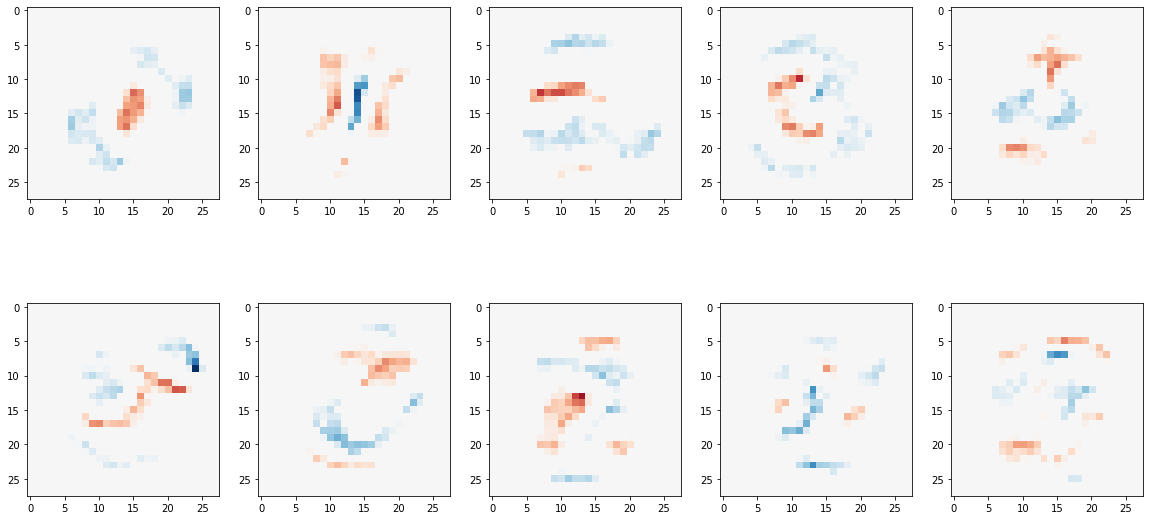

In [94]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems
# Turn up tolerance for faster convergence.
# Use l1 to increase the sparsity of the matrix, which helps in better classification

clf = LogisticRegression(C = 0.01, solver='saga', tol=0.1, penalty='l1', verbose=10)
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score with l1 penalty: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

We can see a huge improvement in the performance. The total-time taken to run the model has dropped to 15s from 3min 19s. Adding tolerence seems to have made the difference. Tolerence helps in faster convergence by defining a stopping criteria. The training stops when the training loss becomes smaller than the threshold defined by the tolerence. Sparsity of the classification vectors has increased as well, which helps in better recognition of digits. Let us explore the confusion matrix to see if we can get some insights on the behaviour of our model.

## Confusion Matrix

In [11]:
# move to utils.py

def get_insights_from_confusion_matrix(confusion_matrix):
    n = 2
    print(f'{confusion_matrix} \n')
    
    for i, row in enumerate(confusion_matrix):
        row[i] = 0 # Assign 0 so that the current image is not considered as wrongly predicted (Stupid hack).
        top_misclassifications = row.argsort()[-3:][::-1]  # Get 3 highest values from array and reverse
        print(f'Majority of the images for {i} are wrongly predicted as {row.argmax()}')
        

get_insights_from_confusion_matrix(confusion_matrix(test_labels, predictions))

[[ 958    0    0    3    1   10    4    3    1    0]
 [   0 1110    5    2    0    2    3    2   11    0]
 [   6   10  928   15   10    3   13   11   32    4]
 [   4    1   16  923    1   24    2   10   20    9]
 [   1    3    7    3  920    0    7    4    6   31]
 [   9    2    3   35   10  777   15    6   31    4]
 [   8    3    8    2    6   15  913    2    1    0]
 [   1    7   23    7    6    1    0  949    2   32]
 [   9   11    6   22    7   29   13    9  856   12]
 [   9    8    1    9   21    7    0   20    6  928]] 

Majority of the images for 0 are wrongly predicted as 5
Majority of the images for 1 are wrongly predicted as 8
Majority of the images for 2 are wrongly predicted as 8
Majority of the images for 3 are wrongly predicted as 5
Majority of the images for 4 are wrongly predicted as 9
Majority of the images for 5 are wrongly predicted as 3
Majority of the images for 6 are wrongly predicted as 5
Majority of the images for 7 are wrongly predicted as 9
Majority of the ima

Numbers that have the same pattern seem to be misclassified. Majority of the numbers seem to be wrongly predicted as 5.

## Testing output for sanity check

Let us do a sanity check to see how the images look for both correctly classified and misclassified predictions and see if we can uncover more from the samples.

In [21]:
# Getting indexes for both misclassified and correctly classified images

index = 0
misclassified_images = []
correctly_classified_images = []

for label, predict in zip(test_labels, predictions):
    if label == predict:
        correctly_classified_images.append(index)
    else:
        misclassified_images.append(index)
    index += 1

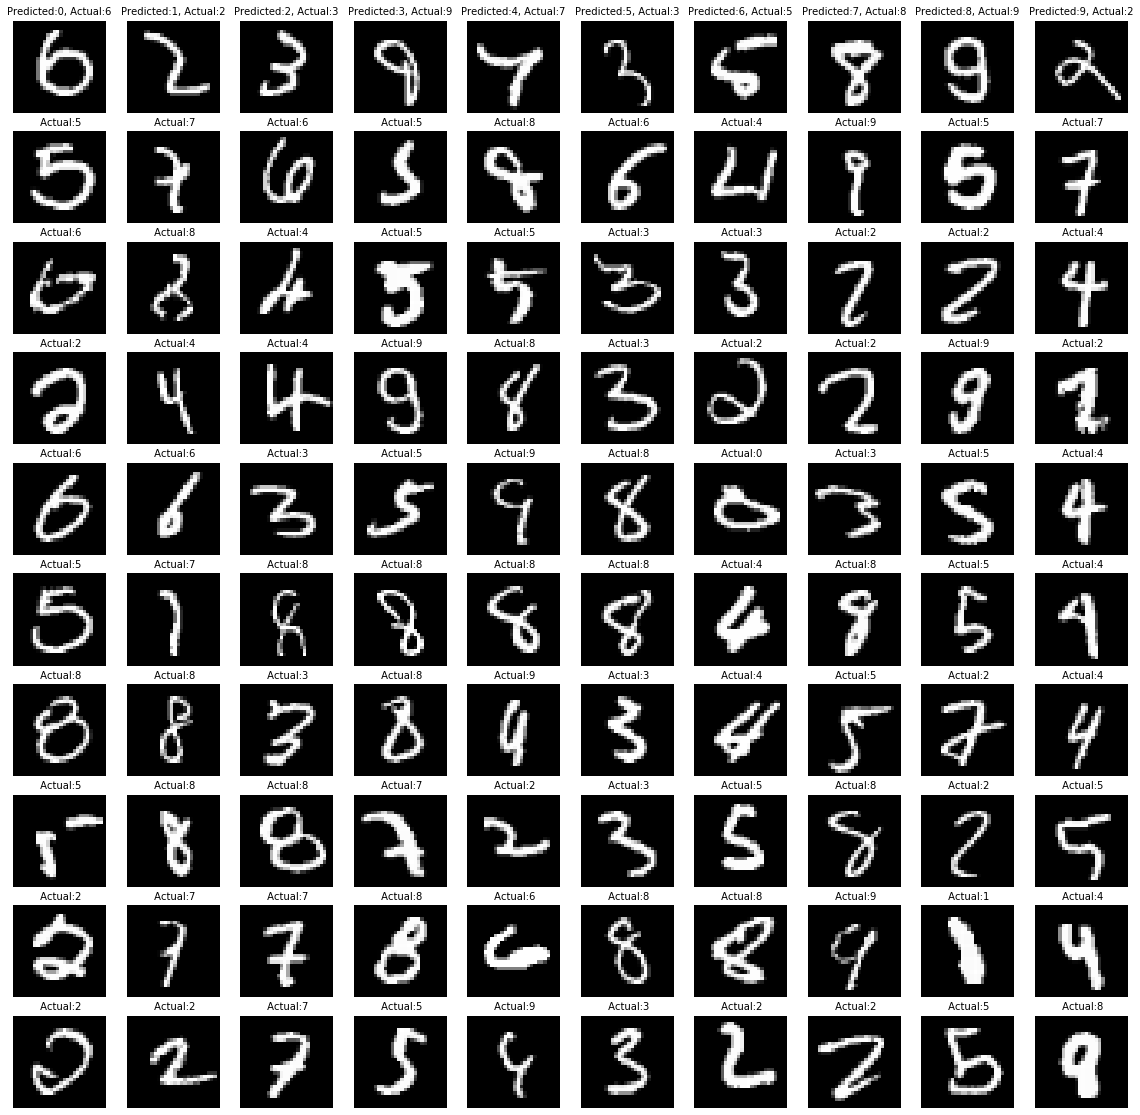

In [44]:
# Displays 10 misclassified images for each digit. 

def display_misclassified_images_for_each_digit(misclassified_indexes, predictions, test_labels, test_data):
    plt.figure(figsize=(20, 20))   
    for i in range(10):
        j = 0
        for misclassified_index in misclassified_indexes:
            if j == 10:
                break # 10 images are printed for given digit i. So, break to print misclassified digits for the next image.
                
            title = ''           
            if j == 0: # to print a column header title.
                title = f'Predicted:{i},' 
            if predictions[misclassified_index] == i:
                plt.subplot(10, 10, i + 1 + (j*10))
                plt.imshow(np.reshape(test_data[misclassified_index], (28, 28)), cmap=plt.cm.gray)
                plt.title(f'{title} Actual:{test_labels[misclassified_index]}', fontsize=10)
                plt.axis('off')
                j += 1
            
            
display_misclassified_images_for_each_digit(misclassified_images, predictions, test_data, test_labels)

From the above misclassifications, below is a summary of observations and how we could improve the model:

1. Few numbers are consistently getting misclassified. Use cross-validation and hyperparameter tuning to improve training and inturn predict better.
2. Blurry, slanty digits and in few cases very fat digits seem to get misclassified. Probably train model with more blurry images or deslant and deskew images before training.

### Grid search and Cross validation

In [92]:
import time
import itertools

def get_custom_grid_search_results(c_values, tol_values, max_iter, solvers, penalities):
    
    i = 0
    iter_results = []
    for c , tol, max_iter, solver, penalty in itertools.product(c_values, tol_values, max_iter, solvers, penalities):
        start = time.time()

        clf = LogisticRegression(C=c, solver=solver, tol=tol, penalty=penalty, max_iter=max_iter)
        clf.fit(train_min_max, train_labels)
        predictions = clf.predict(test_min_max)
        score = accuracy_score(test_labels, predictions)

        end = time.time()
        time_taken = end - start
        
        result = {
            'score': score,
            'c': c,
            'tolerence': tol,
            'max_iter': max_iter,
            'solver': solver,
            'penalty': penalty,
            'time_taken': time_taken
        }

        iter_results.append(result)
        print(f'Iteration {i} completed with parameters {result}')
        i += 1
        
    return iter_results
    

In [90]:
%%time

c_values = [0.0001, 0.001, 0.005, 0.01, 0.5, 0.1]
tol_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
max_iter = [100, 500, 1000]
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga'] # All 4 solvers support multi-class classification
penalities = ['l2'] # 'newton-cg', 'lbfgs', 'sag' do not support l1 penalty

iter_results = get_custom_grid_search_results(c_values, tol_values, max_iter, solvers, penalities)

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Iteration 0 completed with parameters c:0.0001, tolerence:1e-05, max_iter:100, solver:newton-cg, penalty:l2, time taken: 23.629067182540894
Iteration 1 completed with parameters c:0.0001, tolerence:1e-05, max_iter:100, solver:lbfgs, penalty:l2, time taken: 5.611118793487549
Iteration 2 completed with parameters c:0.0001, tolerence:1e-05, max_iter:100, solver:sag, penalty:l2, time taken: 21.750205993652344
Iteration 3 completed with parameters c:0.0001, tolerence:1e-05, max_iter:100, solver:saga, penalty:l2, time taken: 41.18209195137024


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Iteration 4 completed with parameters c:0.0001, tolerence:1e-05, max_iter:500, solver:newton-cg, penalty:l2, time taken: 23.17010807991028
Iteration 5 completed with parameters c:0.0001, tolerence:1e-05, max_iter:500, solver:lbfgs, penalty:l2, time taken: 5.650874853134155
Iteration 6 completed with parameters c:0.0001, tolerence:1e-05, max_iter:500, solver:sag, penalty:l2, time taken: 20.353872537612915
Iteration 7 completed with parameters c:0.0001, tolerence:1e-05, max_iter:500, solver:saga, penalty:l2, time taken: 39.39644122123718


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Iteration 8 completed with parameters c:0.0001, tolerence:1e-05, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 23.71245288848877
Iteration 9 completed with parameters c:0.0001, tolerence:1e-05, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 5.9481730461120605
Iteration 10 completed with parameters c:0.0001, tolerence:1e-05, max_iter:1000, solver:sag, penalty:l2, time taken: 20.49075222015381
Iteration 11 completed with parameters c:0.0001, tolerence:1e-05, max_iter:1000, solver:saga, penalty:l2, time taken: 39.56791806221008
Iteration 12 completed with parameters c:0.0001, tolerence:0.0001, max_iter:100, solver:newton-cg, penalty:l2, time taken: 16.861250400543213
Iteration 13 completed with parameters c:0.0001, tolerence:0.0001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 5.689311981201172
Iteration 14 completed with parameters c:0.0001, tolerence:0.0001, max_iter:100, solver:sag, penalty:l2, time taken: 17.6898250579834
Iteration 15 completed with parameters 

Iteration 69 completed with parameters c:0.0001, tolerence:1, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 5.620326519012451
Iteration 70 completed with parameters c:0.0001, tolerence:1, max_iter:1000, solver:sag, penalty:l2, time taken: 1.5836408138275146
Iteration 71 completed with parameters c:0.0001, tolerence:1, max_iter:1000, solver:saga, penalty:l2, time taken: 2.1403729915618896
Iteration 72 completed with parameters c:0.001, tolerence:1e-05, max_iter:100, solver:newton-cg, penalty:l2, time taken: 20.964505434036255


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 73 completed with parameters c:0.001, tolerence:1e-05, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.942345380783081
Iteration 74 completed with parameters c:0.001, tolerence:1e-05, max_iter:100, solver:sag, penalty:l2, time taken: 28.988917350769043
Iteration 75 completed with parameters c:0.001, tolerence:1e-05, max_iter:100, solver:saga, penalty:l2, time taken: 42.87333536148071
Iteration 76 completed with parameters c:0.001, tolerence:1e-05, max_iter:500, solver:newton-cg, penalty:l2, time taken: 20.64022994041443
Iteration 77 completed with parameters c:0.001, tolerence:1e-05, max_iter:500, solver:lbfgs, penalty:l2, time taken: 12.725300550460815
Iteration 78 completed with parameters c:0.001, tolerence:1e-05, max_iter:500, solver:sag, penalty:l2, time taken: 24.37823796272278
Iteration 79 completed with parameters c:0.001, tolerence:1e-05, max_iter:500, solver:saga, penalty:l2, time taken: 39.042287826538086
Iteration 80 completed with parameters c:0.001, tolere

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 85 completed with parameters c:0.001, tolerence:0.0001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.795271158218384
Iteration 86 completed with parameters c:0.001, tolerence:0.0001, max_iter:100, solver:sag, penalty:l2, time taken: 18.70820188522339
Iteration 87 completed with parameters c:0.001, tolerence:0.0001, max_iter:100, solver:saga, penalty:l2, time taken: 33.11656856536865
Iteration 88 completed with parameters c:0.001, tolerence:0.0001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 17.35825753211975
Iteration 89 completed with parameters c:0.001, tolerence:0.0001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 12.882254362106323
Iteration 90 completed with parameters c:0.001, tolerence:0.0001, max_iter:500, solver:sag, penalty:l2, time taken: 18.801393508911133
Iteration 91 completed with parameters c:0.001, tolerence:0.0001, max_iter:500, solver:saga, penalty:l2, time taken: 33.204121828079224
Iteration 92 completed with parameters c:0.001,

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 97 completed with parameters c:0.001, tolerence:0.001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.876298904418945
Iteration 98 completed with parameters c:0.001, tolerence:0.001, max_iter:100, solver:sag, penalty:l2, time taken: 16.003692150115967
Iteration 99 completed with parameters c:0.001, tolerence:0.001, max_iter:100, solver:saga, penalty:l2, time taken: 21.420676946640015
Iteration 100 completed with parameters c:0.001, tolerence:0.001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 15.807188272476196
Iteration 101 completed with parameters c:0.001, tolerence:0.001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 12.872034311294556
Iteration 102 completed with parameters c:0.001, tolerence:0.001, max_iter:500, solver:sag, penalty:l2, time taken: 14.490410804748535
Iteration 103 completed with parameters c:0.001, tolerence:0.001, max_iter:500, solver:saga, penalty:l2, time taken: 23.394777059555054
Iteration 104 completed with parameters c:0.001

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 109 completed with parameters c:0.001, tolerence:0.01, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.874544382095337
Iteration 110 completed with parameters c:0.001, tolerence:0.01, max_iter:100, solver:sag, penalty:l2, time taken: 8.736822128295898
Iteration 111 completed with parameters c:0.001, tolerence:0.01, max_iter:100, solver:saga, penalty:l2, time taken: 15.650033950805664
Iteration 112 completed with parameters c:0.001, tolerence:0.01, max_iter:500, solver:newton-cg, penalty:l2, time taken: 13.627200841903687
Iteration 113 completed with parameters c:0.001, tolerence:0.01, max_iter:500, solver:lbfgs, penalty:l2, time taken: 12.80170202255249
Iteration 114 completed with parameters c:0.001, tolerence:0.01, max_iter:500, solver:sag, penalty:l2, time taken: 8.792433500289917
Iteration 115 completed with parameters c:0.001, tolerence:0.01, max_iter:500, solver:saga, penalty:l2, time taken: 15.579819679260254
Iteration 116 completed with parameters c:0.001, toler

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 121 completed with parameters c:0.001, tolerence:0.1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.805053472518921
Iteration 122 completed with parameters c:0.001, tolerence:0.1, max_iter:100, solver:sag, penalty:l2, time taken: 3.0479660034179688
Iteration 123 completed with parameters c:0.001, tolerence:0.1, max_iter:100, solver:saga, penalty:l2, time taken: 5.929934740066528
Iteration 124 completed with parameters c:0.001, tolerence:0.1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 10.5184326171875
Iteration 125 completed with parameters c:0.001, tolerence:0.1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 12.862839460372925
Iteration 126 completed with parameters c:0.001, tolerence:0.1, max_iter:500, solver:sag, penalty:l2, time taken: 3.0521178245544434
Iteration 127 completed with parameters c:0.001, tolerence:0.1, max_iter:500, solver:saga, penalty:l2, time taken: 5.94424033164978
Iteration 128 completed with parameters c:0.001, tolerence:0.1,

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 133 completed with parameters c:0.001, tolerence:1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.916582107543945
Iteration 134 completed with parameters c:0.001, tolerence:1, max_iter:100, solver:sag, penalty:l2, time taken: 1.5993306636810303
Iteration 135 completed with parameters c:0.001, tolerence:1, max_iter:100, solver:saga, penalty:l2, time taken: 2.054074287414551
Iteration 136 completed with parameters c:0.001, tolerence:1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 8.469490766525269
Iteration 137 completed with parameters c:0.001, tolerence:1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 10.347987413406372
Iteration 138 completed with parameters c:0.001, tolerence:1, max_iter:500, solver:sag, penalty:l2, time taken: 1.5724830627441406
Iteration 139 completed with parameters c:0.001, tolerence:1, max_iter:500, solver:saga, penalty:l2, time taken: 2.073012113571167
Iteration 140 completed with parameters c:0.001, tolerence:1, max_iter:1000

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 145 completed with parameters c:0.005, tolerence:1e-05, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.908540725708008
Iteration 146 completed with parameters c:0.005, tolerence:1e-05, max_iter:100, solver:sag, penalty:l2, time taken: 31.67689538002014
Iteration 147 completed with parameters c:0.005, tolerence:1e-05, max_iter:100, solver:saga, penalty:l2, time taken: 70.03308248519897
Iteration 148 completed with parameters c:0.005, tolerence:1e-05, max_iter:500, solver:newton-cg, penalty:l2, time taken: 25.152828216552734
Iteration 149 completed with parameters c:0.005, tolerence:1e-05, max_iter:500, solver:lbfgs, penalty:l2, time taken: 17.205576181411743
Iteration 150 completed with parameters c:0.005, tolerence:1e-05, max_iter:500, solver:sag, penalty:l2, time taken: 31.683427333831787
Iteration 151 completed with parameters c:0.005, tolerence:1e-05, max_iter:500, solver:saga, penalty:l2, time taken: 69.88574552536011
Iteration 152 completed with parameters c:0.005

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 157 completed with parameters c:0.005, tolerence:0.0001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.717362403869629
Iteration 158 completed with parameters c:0.005, tolerence:0.0001, max_iter:100, solver:sag, penalty:l2, time taken: 23.042343616485596
Iteration 159 completed with parameters c:0.005, tolerence:0.0001, max_iter:100, solver:saga, penalty:l2, time taken: 50.65340328216553
Iteration 160 completed with parameters c:0.005, tolerence:0.0001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 23.310311794281006
Iteration 161 completed with parameters c:0.005, tolerence:0.0001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 17.333906650543213
Iteration 162 completed with parameters c:0.005, tolerence:0.0001, max_iter:500, solver:sag, penalty:l2, time taken: 25.988059282302856
Iteration 163 completed with parameters c:0.005, tolerence:0.0001, max_iter:500, solver:saga, penalty:l2, time taken: 52.583094358444214
Iteration 164 completed with parameter

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 169 completed with parameters c:0.005, tolerence:0.001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.882888555526733
Iteration 170 completed with parameters c:0.005, tolerence:0.001, max_iter:100, solver:sag, penalty:l2, time taken: 17.353003978729248
Iteration 171 completed with parameters c:0.005, tolerence:0.001, max_iter:100, solver:saga, penalty:l2, time taken: 32.90774846076965
Iteration 172 completed with parameters c:0.005, tolerence:0.001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 21.13561511039734
Iteration 173 completed with parameters c:0.005, tolerence:0.001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 17.370038986206055
Iteration 174 completed with parameters c:0.005, tolerence:0.001, max_iter:500, solver:sag, penalty:l2, time taken: 18.83231806755066
Iteration 175 completed with parameters c:0.005, tolerence:0.001, max_iter:500, solver:saga, penalty:l2, time taken: 32.98133683204651
Iteration 176 completed with parameters c:0.005,

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 181 completed with parameters c:0.005, tolerence:0.01, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.756519556045532
Iteration 182 completed with parameters c:0.005, tolerence:0.01, max_iter:100, solver:sag, penalty:l2, time taken: 11.60433316230774
Iteration 183 completed with parameters c:0.005, tolerence:0.01, max_iter:100, solver:saga, penalty:l2, time taken: 17.807690143585205
Iteration 184 completed with parameters c:0.005, tolerence:0.01, max_iter:500, solver:newton-cg, penalty:l2, time taken: 17.0327467918396
Iteration 185 completed with parameters c:0.005, tolerence:0.01, max_iter:500, solver:lbfgs, penalty:l2, time taken: 17.31448769569397
Iteration 186 completed with parameters c:0.005, tolerence:0.01, max_iter:500, solver:sag, penalty:l2, time taken: 11.704923868179321
Iteration 187 completed with parameters c:0.005, tolerence:0.01, max_iter:500, solver:saga, penalty:l2, time taken: 15.767371654510498
Iteration 188 completed with parameters c:0.005, tolere

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 193 completed with parameters c:0.005, tolerence:0.1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.731811046600342
Iteration 194 completed with parameters c:0.005, tolerence:0.1, max_iter:100, solver:sag, penalty:l2, time taken: 4.488599061965942
Iteration 195 completed with parameters c:0.005, tolerence:0.1, max_iter:100, solver:saga, penalty:l2, time taken: 5.949018955230713
Iteration 196 completed with parameters c:0.005, tolerence:0.1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 13.995047569274902
Iteration 197 completed with parameters c:0.005, tolerence:0.1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 17.07673716545105
Iteration 198 completed with parameters c:0.005, tolerence:0.1, max_iter:500, solver:sag, penalty:l2, time taken: 5.916467905044556
Iteration 199 completed with parameters c:0.005, tolerence:0.1, max_iter:500, solver:saga, penalty:l2, time taken: 5.947141885757446
Iteration 200 completed with parameters c:0.005, tolerence:0.1,

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 205 completed with parameters c:0.005, tolerence:1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.637278079986572
Iteration 206 completed with parameters c:0.005, tolerence:1, max_iter:100, solver:sag, penalty:l2, time taken: 1.620495080947876
Iteration 207 completed with parameters c:0.005, tolerence:1, max_iter:100, solver:saga, penalty:l2, time taken: 2.0703208446502686
Iteration 208 completed with parameters c:0.005, tolerence:1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 11.409287691116333
Iteration 209 completed with parameters c:0.005, tolerence:1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 13.279997825622559
Iteration 210 completed with parameters c:0.005, tolerence:1, max_iter:500, solver:sag, penalty:l2, time taken: 1.5815205574035645
Iteration 211 completed with parameters c:0.005, tolerence:1, max_iter:500, solver:saga, penalty:l2, time taken: 2.083263397216797
Iteration 212 completed with parameters c:0.005, tolerence:1, max_iter:100

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 217 completed with parameters c:0.01, tolerence:1e-05, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.8191397190094
Iteration 218 completed with parameters c:0.01, tolerence:1e-05, max_iter:100, solver:sag, penalty:l2, time taken: 34.59717512130737
Iteration 219 completed with parameters c:0.01, tolerence:1e-05, max_iter:100, solver:saga, penalty:l2, time taken: 87.6533682346344
Iteration 220 completed with parameters c:0.01, tolerence:1e-05, max_iter:500, solver:newton-cg, penalty:l2, time taken: 24.87247085571289
Iteration 221 completed with parameters c:0.01, tolerence:1e-05, max_iter:500, solver:lbfgs, penalty:l2, time taken: 18.658077239990234
Iteration 222 completed with parameters c:0.01, tolerence:1e-05, max_iter:500, solver:sag, penalty:l2, time taken: 34.75721335411072
Iteration 223 completed with parameters c:0.01, tolerence:1e-05, max_iter:500, solver:saga, penalty:l2, time taken: 89.95808267593384
Iteration 224 completed with parameters c:0.01, tolerence:1

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 229 completed with parameters c:0.01, tolerence:0.0001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.893621921539307
Iteration 230 completed with parameters c:0.01, tolerence:0.0001, max_iter:100, solver:sag, penalty:l2, time taken: 27.403862953186035
Iteration 231 completed with parameters c:0.01, tolerence:0.0001, max_iter:100, solver:saga, penalty:l2, time taken: 64.34962677955627
Iteration 232 completed with parameters c:0.01, tolerence:0.0001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 25.234565496444702
Iteration 233 completed with parameters c:0.01, tolerence:0.0001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 18.708624839782715
Iteration 234 completed with parameters c:0.01, tolerence:0.0001, max_iter:500, solver:sag, penalty:l2, time taken: 27.505301237106323
Iteration 235 completed with parameters c:0.01, tolerence:0.0001, max_iter:500, solver:saga, penalty:l2, time taken: 62.36051082611084
Iteration 236 completed with parameters c:0.01

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 241 completed with parameters c:0.01, tolerence:0.001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.809618949890137
Iteration 242 completed with parameters c:0.01, tolerence:0.001, max_iter:100, solver:sag, penalty:l2, time taken: 20.0795419216156
Iteration 243 completed with parameters c:0.01, tolerence:0.001, max_iter:100, solver:saga, penalty:l2, time taken: 36.997331380844116
Iteration 244 completed with parameters c:0.01, tolerence:0.001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 20.93024444580078
Iteration 245 completed with parameters c:0.01, tolerence:0.001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 19.325629234313965
Iteration 246 completed with parameters c:0.01, tolerence:0.001, max_iter:500, solver:sag, penalty:l2, time taken: 20.17648959159851
Iteration 247 completed with parameters c:0.01, tolerence:0.001, max_iter:500, solver:saga, penalty:l2, time taken: 36.97514629364014
Iteration 248 completed with parameters c:0.01, tolerenc

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 253 completed with parameters c:0.01, tolerence:0.01, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.730172395706177
Iteration 254 completed with parameters c:0.01, tolerence:0.01, max_iter:100, solver:sag, penalty:l2, time taken: 14.44818115234375
Iteration 255 completed with parameters c:0.01, tolerence:0.01, max_iter:100, solver:saga, penalty:l2, time taken: 15.611154794692993
Iteration 256 completed with parameters c:0.01, tolerence:0.01, max_iter:500, solver:newton-cg, penalty:l2, time taken: 17.538262367248535
Iteration 257 completed with parameters c:0.01, tolerence:0.01, max_iter:500, solver:lbfgs, penalty:l2, time taken: 18.091034412384033
Iteration 258 completed with parameters c:0.01, tolerence:0.01, max_iter:500, solver:sag, penalty:l2, time taken: 14.498589277267456
Iteration 259 completed with parameters c:0.01, tolerence:0.01, max_iter:500, solver:saga, penalty:l2, time taken: 15.673752784729004
Iteration 260 completed with parameters c:0.01, tolerence:0

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 265 completed with parameters c:0.01, tolerence:0.1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.75305438041687
Iteration 266 completed with parameters c:0.01, tolerence:0.1, max_iter:100, solver:sag, penalty:l2, time taken: 5.804997205734253
Iteration 267 completed with parameters c:0.01, tolerence:0.1, max_iter:100, solver:saga, penalty:l2, time taken: 5.96935772895813
Iteration 268 completed with parameters c:0.01, tolerence:0.1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 12.78508996963501
Iteration 269 completed with parameters c:0.01, tolerence:0.1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 18.302348852157593
Iteration 270 completed with parameters c:0.01, tolerence:0.1, max_iter:500, solver:sag, penalty:l2, time taken: 5.8968586921691895
Iteration 271 completed with parameters c:0.01, tolerence:0.1, max_iter:500, solver:saga, penalty:l2, time taken: 5.961738348007202
Iteration 272 completed with parameters c:0.01, tolerence:0.1, max_iter

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 277 completed with parameters c:0.01, tolerence:1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.779925346374512
Iteration 278 completed with parameters c:0.01, tolerence:1, max_iter:100, solver:sag, penalty:l2, time taken: 1.588223934173584
Iteration 279 completed with parameters c:0.01, tolerence:1, max_iter:100, solver:saga, penalty:l2, time taken: 2.084470272064209
Iteration 280 completed with parameters c:0.01, tolerence:1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 10.018331050872803
Iteration 281 completed with parameters c:0.01, tolerence:1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 13.657138109207153
Iteration 282 completed with parameters c:0.01, tolerence:1, max_iter:500, solver:sag, penalty:l2, time taken: 1.5807440280914307
Iteration 283 completed with parameters c:0.01, tolerence:1, max_iter:500, solver:saga, penalty:l2, time taken: 2.1121666431427
Iteration 284 completed with parameters c:0.01, tolerence:1, max_iter:1000, solver:n

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 289 completed with parameters c:0.5, tolerence:1e-05, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.357608556747437


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 290 completed with parameters c:0.5, tolerence:1e-05, max_iter:100, solver:sag, penalty:l2, time taken: 143.93167996406555


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 291 completed with parameters c:0.5, tolerence:1e-05, max_iter:100, solver:saga, penalty:l2, time taken: 195.10388708114624
Iteration 292 completed with parameters c:0.5, tolerence:1e-05, max_iter:500, solver:newton-cg, penalty:l2, time taken: 55.7594780921936


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 293 completed with parameters c:0.5, tolerence:1e-05, max_iter:500, solver:lbfgs, penalty:l2, time taken: 46.94046711921692
Iteration 294 completed with parameters c:0.5, tolerence:1e-05, max_iter:500, solver:sag, penalty:l2, time taken: 363.85318183898926
Iteration 295 completed with parameters c:0.5, tolerence:1e-05, max_iter:500, solver:saga, penalty:l2, time taken: 907.6981809139252
Iteration 296 completed with parameters c:0.5, tolerence:1e-05, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 57.146257400512695
Iteration 297 completed with parameters c:0.5, tolerence:1e-05, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 60.89091610908508
Iteration 298 completed with parameters c:0.5, tolerence:1e-05, max_iter:1000, solver:sag, penalty:l2, time taken: 364.19259810447693
Iteration 299 completed with parameters c:0.5, tolerence:1e-05, max_iter:1000, solver:saga, penalty:l2, time taken: 908.4666984081268
Iteration 300 completed with parameters c:0.5, tolerence:

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 301 completed with parameters c:0.5, tolerence:0.0001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 10.112885236740112


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 302 completed with parameters c:0.5, tolerence:0.0001, max_iter:100, solver:sag, penalty:l2, time taken: 146.10769534111023


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 303 completed with parameters c:0.5, tolerence:0.0001, max_iter:100, solver:saga, penalty:l2, time taken: 194.80122137069702
Iteration 304 completed with parameters c:0.5, tolerence:0.0001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 47.15323328971863


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 305 completed with parameters c:0.5, tolerence:0.0001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 47.48021984100342
Iteration 306 completed with parameters c:0.5, tolerence:0.0001, max_iter:500, solver:sag, penalty:l2, time taken: 244.55365133285522
Iteration 307 completed with parameters c:0.5, tolerence:0.0001, max_iter:500, solver:saga, penalty:l2, time taken: 582.8059446811676
Iteration 308 completed with parameters c:0.5, tolerence:0.0001, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 47.68871569633484
Iteration 309 completed with parameters c:0.5, tolerence:0.0001, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 60.358426332473755
Iteration 310 completed with parameters c:0.5, tolerence:0.0001, max_iter:1000, solver:sag, penalty:l2, time taken: 245.6188886165619
Iteration 311 completed with parameters c:0.5, tolerence:0.0001, max_iter:1000, solver:saga, penalty:l2, time taken: 581.9732503890991
Iteration 312 completed with parameters c:0.5, tole

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 313 completed with parameters c:0.5, tolerence:0.001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.512037992477417
Iteration 314 completed with parameters c:0.5, tolerence:0.001, max_iter:100, solver:sag, penalty:l2, time taken: 129.24354004859924


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 315 completed with parameters c:0.5, tolerence:0.001, max_iter:100, solver:saga, penalty:l2, time taken: 192.47945308685303
Iteration 316 completed with parameters c:0.5, tolerence:0.001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 39.346734046936035


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 317 completed with parameters c:0.5, tolerence:0.001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 45.999430894851685
Iteration 318 completed with parameters c:0.5, tolerence:0.001, max_iter:500, solver:sag, penalty:l2, time taken: 128.74758744239807
Iteration 319 completed with parameters c:0.5, tolerence:0.001, max_iter:500, solver:saga, penalty:l2, time taken: 262.0082993507385
Iteration 320 completed with parameters c:0.5, tolerence:0.001, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 39.22539925575256
Iteration 321 completed with parameters c:0.5, tolerence:0.001, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 57.12234830856323
Iteration 322 completed with parameters c:0.5, tolerence:0.001, max_iter:1000, solver:sag, penalty:l2, time taken: 127.1175811290741
Iteration 323 completed with parameters c:0.5, tolerence:0.001, max_iter:1000, solver:saga, penalty:l2, time taken: 263.38983130455017
Iteration 324 completed with parameters c:0.5, tolerence:

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 325 completed with parameters c:0.5, tolerence:0.01, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.09531831741333
Iteration 326 completed with parameters c:0.5, tolerence:0.01, max_iter:100, solver:sag, penalty:l2, time taken: 39.03930354118347
Iteration 327 completed with parameters c:0.5, tolerence:0.01, max_iter:100, solver:saga, penalty:l2, time taken: 68.12065482139587
Iteration 328 completed with parameters c:0.5, tolerence:0.01, max_iter:500, solver:newton-cg, penalty:l2, time taken: 33.661409854888916


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 329 completed with parameters c:0.5, tolerence:0.01, max_iter:500, solver:lbfgs, penalty:l2, time taken: 46.023372173309326
Iteration 330 completed with parameters c:0.5, tolerence:0.01, max_iter:500, solver:sag, penalty:l2, time taken: 40.68743371963501
Iteration 331 completed with parameters c:0.5, tolerence:0.01, max_iter:500, solver:saga, penalty:l2, time taken: 66.33970761299133
Iteration 332 completed with parameters c:0.5, tolerence:0.01, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 33.596089124679565
Iteration 333 completed with parameters c:0.5, tolerence:0.01, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 57.50741767883301
Iteration 334 completed with parameters c:0.5, tolerence:0.01, max_iter:1000, solver:sag, penalty:l2, time taken: 40.63962745666504
Iteration 335 completed with parameters c:0.5, tolerence:0.01, max_iter:1000, solver:saga, penalty:l2, time taken: 66.01873397827148
Iteration 336 completed with parameters c:0.5, tolerence:0.1, max

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 337 completed with parameters c:0.5, tolerence:0.1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.081277847290039
Iteration 338 completed with parameters c:0.5, tolerence:0.1, max_iter:100, solver:sag, penalty:l2, time taken: 7.590789556503296
Iteration 339 completed with parameters c:0.5, tolerence:0.1, max_iter:100, solver:saga, penalty:l2, time taken: 8.128188133239746
Iteration 340 completed with parameters c:0.5, tolerence:0.1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 24.15504813194275


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 341 completed with parameters c:0.5, tolerence:0.1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 45.76856875419617
Iteration 342 completed with parameters c:0.5, tolerence:0.1, max_iter:500, solver:sag, penalty:l2, time taken: 7.6082000732421875
Iteration 343 completed with parameters c:0.5, tolerence:0.1, max_iter:500, solver:saga, penalty:l2, time taken: 8.126858234405518
Iteration 344 completed with parameters c:0.5, tolerence:0.1, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 24.224735498428345
Iteration 345 completed with parameters c:0.5, tolerence:0.1, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 51.64704084396362
Iteration 346 completed with parameters c:0.5, tolerence:0.1, max_iter:1000, solver:sag, penalty:l2, time taken: 7.285833358764648
Iteration 347 completed with parameters c:0.5, tolerence:0.1, max_iter:1000, solver:saga, penalty:l2, time taken: 7.815021991729736
Iteration 348 completed with parameters c:0.5, tolerence:1, max_iter:100

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 349 completed with parameters c:0.5, tolerence:1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.266820192337036
Iteration 350 completed with parameters c:0.5, tolerence:1, max_iter:100, solver:sag, penalty:l2, time taken: 1.5708003044128418
Iteration 351 completed with parameters c:0.5, tolerence:1, max_iter:100, solver:saga, penalty:l2, time taken: 2.067493200302124
Iteration 352 completed with parameters c:0.5, tolerence:1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 16.821282625198364
Iteration 353 completed with parameters c:0.5, tolerence:1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 32.796430587768555
Iteration 354 completed with parameters c:0.5, tolerence:1, max_iter:500, solver:sag, penalty:l2, time taken: 1.5493757724761963
Iteration 355 completed with parameters c:0.5, tolerence:1, max_iter:500, solver:saga, penalty:l2, time taken: 2.060772180557251
Iteration 356 completed with parameters c:0.5, tolerence:1, max_iter:1000, solver:newton

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 361 completed with parameters c:0.1, tolerence:1e-05, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.261828184127808
Iteration 362 completed with parameters c:0.1, tolerence:1e-05, max_iter:100, solver:sag, penalty:l2, time taken: 79.43773412704468


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 363 completed with parameters c:0.1, tolerence:1e-05, max_iter:100, solver:saga, penalty:l2, time taken: 192.26016783714294
Iteration 364 completed with parameters c:0.1, tolerence:1e-05, max_iter:500, solver:newton-cg, penalty:l2, time taken: 31.979447841644287
Iteration 365 completed with parameters c:0.1, tolerence:1e-05, max_iter:500, solver:lbfgs, penalty:l2, time taken: 28.60852289199829
Iteration 366 completed with parameters c:0.1, tolerence:1e-05, max_iter:500, solver:sag, penalty:l2, time taken: 81.04260849952698
Iteration 367 completed with parameters c:0.1, tolerence:1e-05, max_iter:500, solver:saga, penalty:l2, time taken: 217.61932921409607
Iteration 368 completed with parameters c:0.1, tolerence:1e-05, max_iter:1000, solver:newton-cg, penalty:l2, time taken: 31.839597940444946
Iteration 369 completed with parameters c:0.1, tolerence:1e-05, max_iter:1000, solver:lbfgs, penalty:l2, time taken: 28.666378259658813
Iteration 370 completed with parameters c:0.1, tole

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 373 completed with parameters c:0.1, tolerence:0.0001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.290102243423462
Iteration 374 completed with parameters c:0.1, tolerence:0.0001, max_iter:100, solver:sag, penalty:l2, time taken: 59.062156200408936
Iteration 375 completed with parameters c:0.1, tolerence:0.0001, max_iter:100, solver:saga, penalty:l2, time taken: 155.94862151145935
Iteration 376 completed with parameters c:0.1, tolerence:0.0001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 29.28282356262207
Iteration 377 completed with parameters c:0.1, tolerence:0.0001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 28.760642528533936
Iteration 378 completed with parameters c:0.1, tolerence:0.0001, max_iter:500, solver:sag, penalty:l2, time taken: 59.08798146247864
Iteration 379 completed with parameters c:0.1, tolerence:0.0001, max_iter:500, solver:saga, penalty:l2, time taken: 153.7894868850708
Iteration 380 completed with parameters c:0.1, toleren

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 385 completed with parameters c:0.1, tolerence:0.001, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.179760217666626
Iteration 386 completed with parameters c:0.1, tolerence:0.001, max_iter:100, solver:sag, penalty:l2, time taken: 38.86883091926575
Iteration 387 completed with parameters c:0.1, tolerence:0.001, max_iter:100, solver:saga, penalty:l2, time taken: 89.52472424507141
Iteration 388 completed with parameters c:0.1, tolerence:0.001, max_iter:500, solver:newton-cg, penalty:l2, time taken: 23.94596576690674
Iteration 389 completed with parameters c:0.1, tolerence:0.001, max_iter:500, solver:lbfgs, penalty:l2, time taken: 28.369015216827393
Iteration 390 completed with parameters c:0.1, tolerence:0.001, max_iter:500, solver:sag, penalty:l2, time taken: 37.433621644973755
Iteration 391 completed with parameters c:0.1, tolerence:0.001, max_iter:500, solver:saga, penalty:l2, time taken: 87.71385145187378
Iteration 392 completed with parameters c:0.1, tolerence:0.001

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 397 completed with parameters c:0.1, tolerence:0.01, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.293012142181396
Iteration 398 completed with parameters c:0.1, tolerence:0.01, max_iter:100, solver:sag, penalty:l2, time taken: 18.781193494796753
Iteration 399 completed with parameters c:0.1, tolerence:0.01, max_iter:100, solver:saga, penalty:l2, time taken: 35.185680866241455
Iteration 400 completed with parameters c:0.1, tolerence:0.01, max_iter:500, solver:newton-cg, penalty:l2, time taken: 20.070475101470947
Iteration 401 completed with parameters c:0.1, tolerence:0.01, max_iter:500, solver:lbfgs, penalty:l2, time taken: 28.406736612319946
Iteration 402 completed with parameters c:0.1, tolerence:0.01, max_iter:500, solver:sag, penalty:l2, time taken: 18.78027606010437
Iteration 403 completed with parameters c:0.1, tolerence:0.01, max_iter:500, solver:saga, penalty:l2, time taken: 33.2475004196167
Iteration 404 completed with parameters c:0.1, tolerence:0.01, max_i

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 409 completed with parameters c:0.1, tolerence:0.1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.204577207565308
Iteration 410 completed with parameters c:0.1, tolerence:0.1, max_iter:100, solver:sag, penalty:l2, time taken: 8.720156192779541
Iteration 411 completed with parameters c:0.1, tolerence:0.1, max_iter:100, solver:saga, penalty:l2, time taken: 7.934946775436401
Iteration 412 completed with parameters c:0.1, tolerence:0.1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 16.721174716949463
Iteration 413 completed with parameters c:0.1, tolerence:0.1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 27.477297067642212
Iteration 414 completed with parameters c:0.1, tolerence:0.1, max_iter:500, solver:sag, penalty:l2, time taken: 7.315109014511108
Iteration 415 completed with parameters c:0.1, tolerence:0.1, max_iter:500, solver:saga, penalty:l2, time taken: 7.885452747344971
Iteration 416 completed with parameters c:0.1, tolerence:0.1, max_iter:1000,

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iteration 421 completed with parameters c:0.1, tolerence:1, max_iter:100, solver:lbfgs, penalty:l2, time taken: 9.324686765670776
Iteration 422 completed with parameters c:0.1, tolerence:1, max_iter:100, solver:sag, penalty:l2, time taken: 1.5930237770080566
Iteration 423 completed with parameters c:0.1, tolerence:1, max_iter:100, solver:saga, penalty:l2, time taken: 2.083036184310913
Iteration 424 completed with parameters c:0.1, tolerence:1, max_iter:500, solver:newton-cg, penalty:l2, time taken: 11.00446105003357
Iteration 425 completed with parameters c:0.1, tolerence:1, max_iter:500, solver:lbfgs, penalty:l2, time taken: 18.85877275466919
Iteration 426 completed with parameters c:0.1, tolerence:1, max_iter:500, solver:sag, penalty:l2, time taken: 1.5809450149536133
Iteration 427 completed with parameters c:0.1, tolerence:1, max_iter:500, solver:saga, penalty:l2, time taken: 2.097507953643799
Iteration 428 completed with parameters c:0.1, tolerence:1, max_iter:1000, solver:newton-c

As you can see from the above warning, 'lbfgs' failed to converge 90 times out of the 108 times it was run. It seems to have converged for about 6 combinations of c_values and tol_values. 
Sag seems to have reached max_iteration limit for 18 combinations of values
Newtown and saga seems to have converged for all combinations. 
Although convergence is not important in all cases, let us see how the models have performed.

In [ ]:
pd.set_option('display.max_rows', 1000)

results = pd.DataFrame(iter_results)
report = results.sort_values(by='score', ascending=False)
report

From the above table, we can conclude 'saga' seems to be performing well for multi-class classification with a c value of 0.5. 
As we skim through the table, we can notice 2-3 consecutive rows every now and then that the accuracy remains the same for a given solver and c value, only with variations in tol and max_iter. For example, if you observe row 2,3,4, the accuracy remained constant for a given c value and solver, but there were variations in tol and iter. The time taken is almost the same as well.

Let us see how each solver varies.


Since only saga supports l1 penalty, let us do a grid search for saga with l1 penalty.

In [ ]:
%%time

solver = ['saga']
penalty = ['l1']

saga_results = get_custom_grid_search_results(c_values, tol_values, max_iter, solver, penalty)

Iteration 0 completed with parameters {'score': 0.1135, 'c': 0.0001, 'tolerence': 1e-05, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 14.65049958229065}
Iteration 1 completed with parameters {'score': 0.1135, 'c': 0.0001, 'tolerence': 1e-05, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 11.870373725891113}
Iteration 2 completed with parameters {'score': 0.1135, 'c': 0.0001, 'tolerence': 1e-05, 'max_iter': 1000, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 8.88907766342163}
Iteration 3 completed with parameters {'score': 0.1135, 'c': 0.0001, 'tolerence': 0.0001, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 17.49729299545288}
Iteration 4 completed with parameters {'score': 0.1135, 'c': 0.0001, 'tolerence': 0.0001, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 3.1425061225891113}
Iteration 5 completed with parameters {'score': 0.1135, 'c': 0.0001, 'tolerence': 0.0001, 'max_iter': 1000, 'solver': 'saga', 

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 36 completed with parameters {'score': 0.8713, 'c': 0.005, 'tolerence': 1e-05, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 306.779905796051}
Iteration 37 completed with parameters {'score': 0.8713, 'c': 0.005, 'tolerence': 1e-05, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 415.00002455711365}
Iteration 38 completed with parameters {'score': 0.8713, 'c': 0.005, 'tolerence': 1e-05, 'max_iter': 1000, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 414.3888359069824}
Iteration 39 completed with parameters {'score': 0.8713, 'c': 0.005, 'tolerence': 0.0001, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 288.2163956165314}
Iteration 40 completed with parameters {'score': 0.8713, 'c': 0.005, 'tolerence': 0.0001, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 283.81867122650146}
Iteration 41 completed with parameters {'score': 0.8713, 'c': 0.005, 'tolerence': 0.0001, 'max_iter': 1000, 'solver': 'saga', 

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 54 completed with parameters {'score': 0.8931, 'c': 0.01, 'tolerence': 1e-05, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 305.79311633110046}
Iteration 55 completed with parameters {'score': 0.893, 'c': 0.01, 'tolerence': 1e-05, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 650.363272190094}
Iteration 56 completed with parameters {'score': 0.893, 'c': 0.01, 'tolerence': 1e-05, 'max_iter': 1000, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 655.040284872055}


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 57 completed with parameters {'score': 0.8931, 'c': 0.01, 'tolerence': 0.0001, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 304.11023807525635}
Iteration 58 completed with parameters {'score': 0.893, 'c': 0.01, 'tolerence': 0.0001, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 421.5018002986908}
Iteration 59 completed with parameters {'score': 0.893, 'c': 0.01, 'tolerence': 0.0001, 'max_iter': 1000, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 420.2942841053009}
Iteration 60 completed with parameters {'score': 0.8932, 'c': 0.01, 'tolerence': 0.001, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 218.11937761306763}
Iteration 61 completed with parameters {'score': 0.8932, 'c': 0.01, 'tolerence': 0.001, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 222.95591616630554}
Iteration 62 completed with parameters {'score': 0.8932, 'c': 0.01, 'tolerence': 0.001, 'max_iter': 1000, 'solver': 'saga', 'penal

C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 72 completed with parameters {'score': 0.927, 'c': 0.5, 'tolerence': 1e-05, 'max_iter': 100, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 637.2538955211639}


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 73 completed with parameters {'score': 0.9276, 'c': 0.5, 'tolerence': 1e-05, 'max_iter': 500, 'solver': 'saga', 'penalty': 'l1', 'time_taken': 4912.738389253616}


### Shortistling best performing models

Let us pick 10 best performing models from 1 & 2 and apply cross validation on that.

For cross validation, scikit learn has a wide variety of techniques, some of which are:

1) Standard K-fold - every fold is different. The split is chosen in consecutive order without shuffling. <br />
2) Stratified K-fold - a variant of K-fold, that preserves percentage of samples. <br />
3) StratifiedShuffleSplit - A random permutation cross-validator performing stratified splits. This does not guarantee that all folds are different. <br />

Let us try all the above mentioned types for cross validation.

In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import learning_curve

cv_sets = [StratifiedKFold, StratifiedKFold, StratifiedShuffleSplit]
tol = []
C = 0.01
solver = 'saga'
penalty = ['l1', 'l2']

train_sizes_list = []
train_scores_list = []
test_scores_list = []
fit_times_list = []
score_times_list = []


cv = StratifiedKFold(n_splits=5, random_state=0)

estimator = LogisticRegression(C = 0.01, solver='saga', tol=0.1, penalty='l1', verbose=10)

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator, 
                                                                                train_min_max, 
                                                                                train_labels, 
                                                                                cv=cv, 
                                                                                n_jobs=4, 
                                                                                return_times=True)

train_sizes_list.append(train_sizes)
train_scores_list.append(train_scores)
test_scores_list.append(test_scores)
fit_times_list.append(fit_times)
score_times_list.append(score_times)

Text(0.5, 1.0, 'Performance of the model')

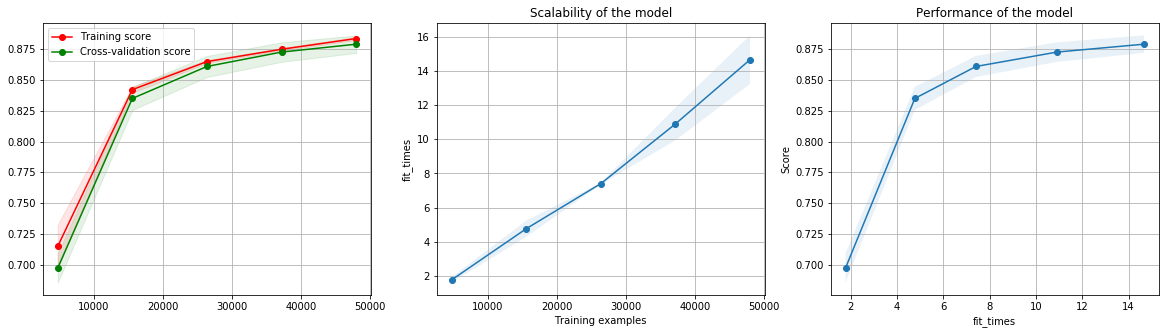

In [57]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

_, axes = plt.subplots(1, 3, figsize=(20, 5))
# Plot learning curve
axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

 C = $\frac 1{\lambda}$

Regularization is used when there are a lot of independent variables, but very less data. The higher weights get more importance and there could be overfitting. Hence we use regularization to reduce the effects of large weights. In our case, since C is the inverse of $\lambda$ the lower C value, the higher effect it has on the weights.



References:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
Confusion matrix: https://www.python-course.eu/confusion_matrix.php
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
Preprocessing
https://fsix.github.io/mnist/
Synthetic data generation:
https://towardsdatascience.com/synthetic-data-generation-a-must-have-skill-for-new-data-scientists-915896c0c1ae
https://towardsdatascience.com/do-you-need-synthetic-data-for-your-ai-project-e7ecc2072d6b
https://towardsdatascience.com/how-uber-uses-synthetic-data-to-speed-up-training-cc989c23ded4
